# 3-body gravitationsl problem
- see https://towardsdatascience.com/modelling-the-three-body-problem-in-classical-mechanics-using-python-9dc270ad7767

In [1]:
#Import scipy
import numpy as np
#import scipy as sci
import scipy.integrate
#Import matplotlib and associated modules for 3D and animations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

In [2]:
#Define universal gravitation constant
G=6.67408e-11 #N-m2/kg2
#Reference quantities
m_nd=1.989e+30 #kg #mass of the sun
r_nd=5.326e+12 #m #distance between stars in Alpha Centauri
v_nd=30000 #m/s #relative velocity of earth around the sun
t_nd=79.91*365*24*3600*0.51 #s #orbital period of Alpha Centauri
#Net constants
K1=G*t_nd*m_nd/(r_nd**2*v_nd)
K2=v_nd*t_nd/r_nd

In [3]:
#Define masses in reduced units
m1=1.1 #Alpha Centauri A
m2=0.907 #Alpha Centauri B
m3=1.0 #Third Star

#Define initial position vectors in reduced units
r1=np.array([-0.5,0,0],dtype="float64") 
r2=np.array([0.5,0,0],dtype="float64") 
r3=np.array([0,1,0],dtype="float64") 

#Define initial velocities in reduced units
v1=np.array([0.01,0.01,0],dtype="float64") 
v2=np.array([-0.05,0,-0.1],dtype="float64")
v3=np.array([0,-0.01,0],dtype="float64")

# Center of mass
r_com=(m1*r1+m2*r2+m3*r3)/(m1+m2+m3)
v_com=(m1*v1+m2*v2+m3*v3)/(m1+m2+m3)


In [4]:
def ThreeBodyEquations(w,t,G,m1,m2,m3):
    r1=w[:3]
    r2=w[3:6]
    r3=w[6:9]
    v1=w[9:12]
    v2=w[12:15]
    v3=w[15:18]
    r12=np.linalg.norm(r2-r1)
    r13=np.linalg.norm(r3-r1)
    r23=np.linalg.norm(r3-r2)
    
    dv1bydt=K1*m2*(r2-r1)/r12**3+K1*m3*(r3-r1)/r13**3
    dv2bydt=K1*m1*(r1-r2)/r12**3+K1*m3*(r3-r2)/r23**3
    dv3bydt=K1*m1*(r1-r3)/r13**3+K1*m2*(r2-r3)/r23**3
    dr1bydt=K2*v1
    dr2bydt=K2*v2
    dr3bydt=K2*v3
    r12_derivs=np.concatenate((dr1bydt,dr2bydt))
    r_derivs=np.concatenate((r12_derivs,dr3bydt))
    v12_derivs=np.concatenate((dv1bydt,dv2bydt))
    v_derivs=np.concatenate((v12_derivs,dv3bydt))
    derivs=np.concatenate((r_derivs,v_derivs))
    return derivs

In [31]:
#Package initial parameters
init_params=np.array([r1,r2,r3,v1,v2,v3]) #Initial parameters
init_params=init_params.flatten() #Flatten to make 1D array
time_span=np.linspace(0,20,50000) #20 orbital periods and 500 points

#Run the ODE solver
three_body_sol=scipy.integrate.odeint(ThreeBodyEquations,init_params,time_span,args=(G,m1,m2,m3))

# Get the coordinates
r1_sol=three_body_sol[:,:3]
r2_sol=three_body_sol[:,3:6]
r3_sol=three_body_sol[:,6:9]

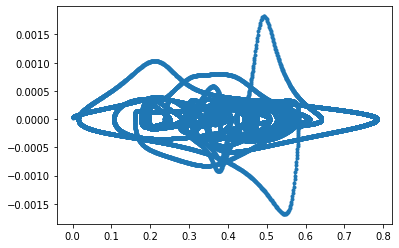

In [32]:
plt.plot(r1_sol[:-1,1],r1_sol[1:,1]-r1_sol[:-1,1],'.-')

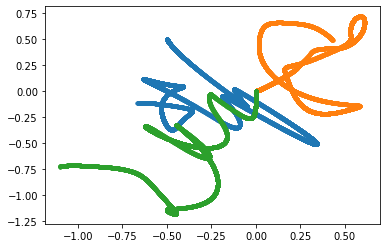

In [33]:
plt.plot(r1_sol[:10000],r2_sol[:10000],'.-')

### Machine learning 
- the first coordinate of the first body

In [105]:
np.concatenate(([X],[X])).shape

(2, 49996)

In [128]:
nSteps = 5
to_predict = 0
predict_from = 0
y = three_body_sol[nSteps+1:,0]
X = [three_body_sol[:-nSteps-1,predict_from]]
for ii in range(nSteps-1):
    i = ii+1
    X = np.concatenate((X,[three_body_sol[i:-(nSteps-i+1),predict_from]]), axis=0)
X = X.T

In [129]:
X.shape

(49994, 5)

In [130]:
y.shape

(49994,)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [132]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
y_stepPredict = []
for i in range(len(X_test)):
    y_stepPredict.append(reg.predict(X_test[i]))

ValueError: Expected 2D array, got 1D array instead:
array=[-0.63323591 -0.63324117 -0.63324614 -0.63325083 -0.63325523].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

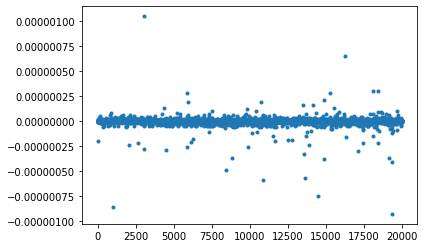

In [134]:
plt.plot(y_test-y_pred,'.')

In [135]:
reg.intercept_

-5.361227017885994e-10

In [136]:
reg.coef_

array([  4.7715284 , -22.96837236,  43.27554006, -38.73206932,
        14.65337322])

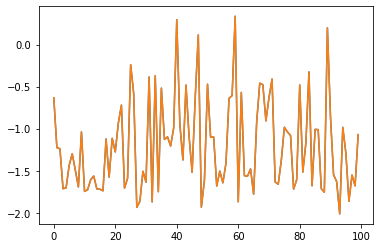

In [140]:
plt.plot(y_pred[:100])
plt.plot(y_test[:100])